In [73]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.moist_physics import sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc
from tqdm.notebook import tqdm
from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
from jobs.theory_lapse.isca.load_ds_quant import ds_quant

### Fraction of days used
In the scaling factor computation, we only include days for which the vertical `mod_parcel1` profile is good. We define *good* as having the error less than 25% and having a smaller error than the `const1` method.

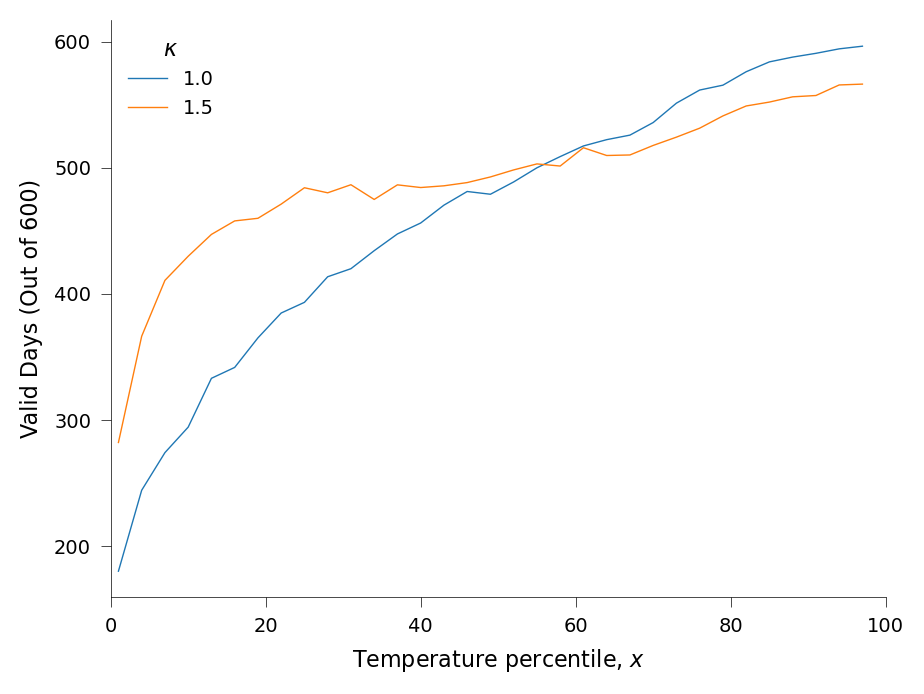

In [4]:
error = {
    key: np.abs(ds_quant[f'{key}1_error'].sum(dim='layer') / ds_quant[f'{key}1_integral'].sum(dim='layer') * 100).isel(
        surf=0)
    for key in ['mod_parcel', 'const']}
mask_use = (error['mod_parcel'] < 25) & (error['mod_parcel'] < error['const'])

lat_weights = np.cos(np.deg2rad(ds_quant.lat))
percentile_label = 'Temperature percentile, $x$'

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    ax.plot(ds_quant.quant, np.average(mask_use.sum(dim='sample').isel(tau_lw=i), axis=1, weights=lat_weights),
            label=f"{mask_use.tau_lw.values[i]:.1f}")
ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
ax.legend(title='$\kappa$')
plt.show()

## Principal Component Analysis
### Initialize data
We initialize data by subtracting the reference values. We obtain reference value for each latitude, and `tau_lw` value. We only use the masked points which have low error for the `mod_parcel1` method to compute the reference values.

In [7]:
ds_pca = ds_quant[['PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']].isel(surf=0)
ds_pca['lapse_mod_D'] = ds_pca.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_pca['lapse_mod_M'] = ds_pca.mod_parcel1_lapse.isel(layer=1) / 1000
ds_pca = ds_pca.drop_vars(['mod_parcel1_lapse'])
ref_method = 'actual'  # Take actual mean values
# ref_method = 'custom'       # Assume follows SQE, and no RH change with warming
if ref_method == 'actual':
    ref_vals = {key: ds_pca[key].where(mask_use).mean(dim=['quant', 'sample']) for key in ds_pca}
else:
    ref_vals = {key: ds_pca[key].where(mask_use).isel(tau_lw=0).mean(dim=['quant', 'sample']) for key in
                ['PREFHT', 'rh_REFHT']}
    ref_vals['lapse_mod_D'] = ref_vals['PREFHT'] * 0
    ref_vals['lapse_mod_M'] = ref_vals['PREFHT'] * 0
ref_vals['TREFHT'] = ds_quant.TREFHT.isel(surf=0).where(mask_use).mean(dim=['quant', 'sample'])
ds_ref = xr.Dataset(ref_vals)

# Compute ref
get_temp_mod_parcel_xr = wrap_with_apply_ufunc(get_temp_mod_parcel)  # make function work with xarray
ds_ref['T_ft_env'] = get_temp_mod_parcel_xr(ref_vals['rh_REFHT'], ref_vals['PREFHT'], ds_quant.p_ft,
                                            ref_vals['lapse_mod_D'],
                                            ref_vals['lapse_mod_M'], ref_vals['TREFHT'],
                                            temp_surf_lcl_calc=ds_quant.temp_surf_lcl_calc)
for key in ds_pca:
    ds_pca[key] = ds_pca[key] - ds_ref[key]

### Correlation between variables
Some variables are correlated as shown below e.g. $T_{FT}$ is larger for smaller $p_s$ and $\eta_D$ is larger for smaller $r_s$.

These correlations indicate the need to do PCA on the raw variables before clustering. The motivation to do clustering can also be seen here, with distinct clusters apparent e.g. there appears to be a dry and moist regime for the highest latitude (yellow), but few points with $r_s\approx 0$.

In the plot below, a separate reference value is removed for each latitude and $\kappa$. Hence a different set of markers for each of these, all centered around zero for each variable. Only masked points are shown, for which the `mod_parcel` fitting is appropriate.

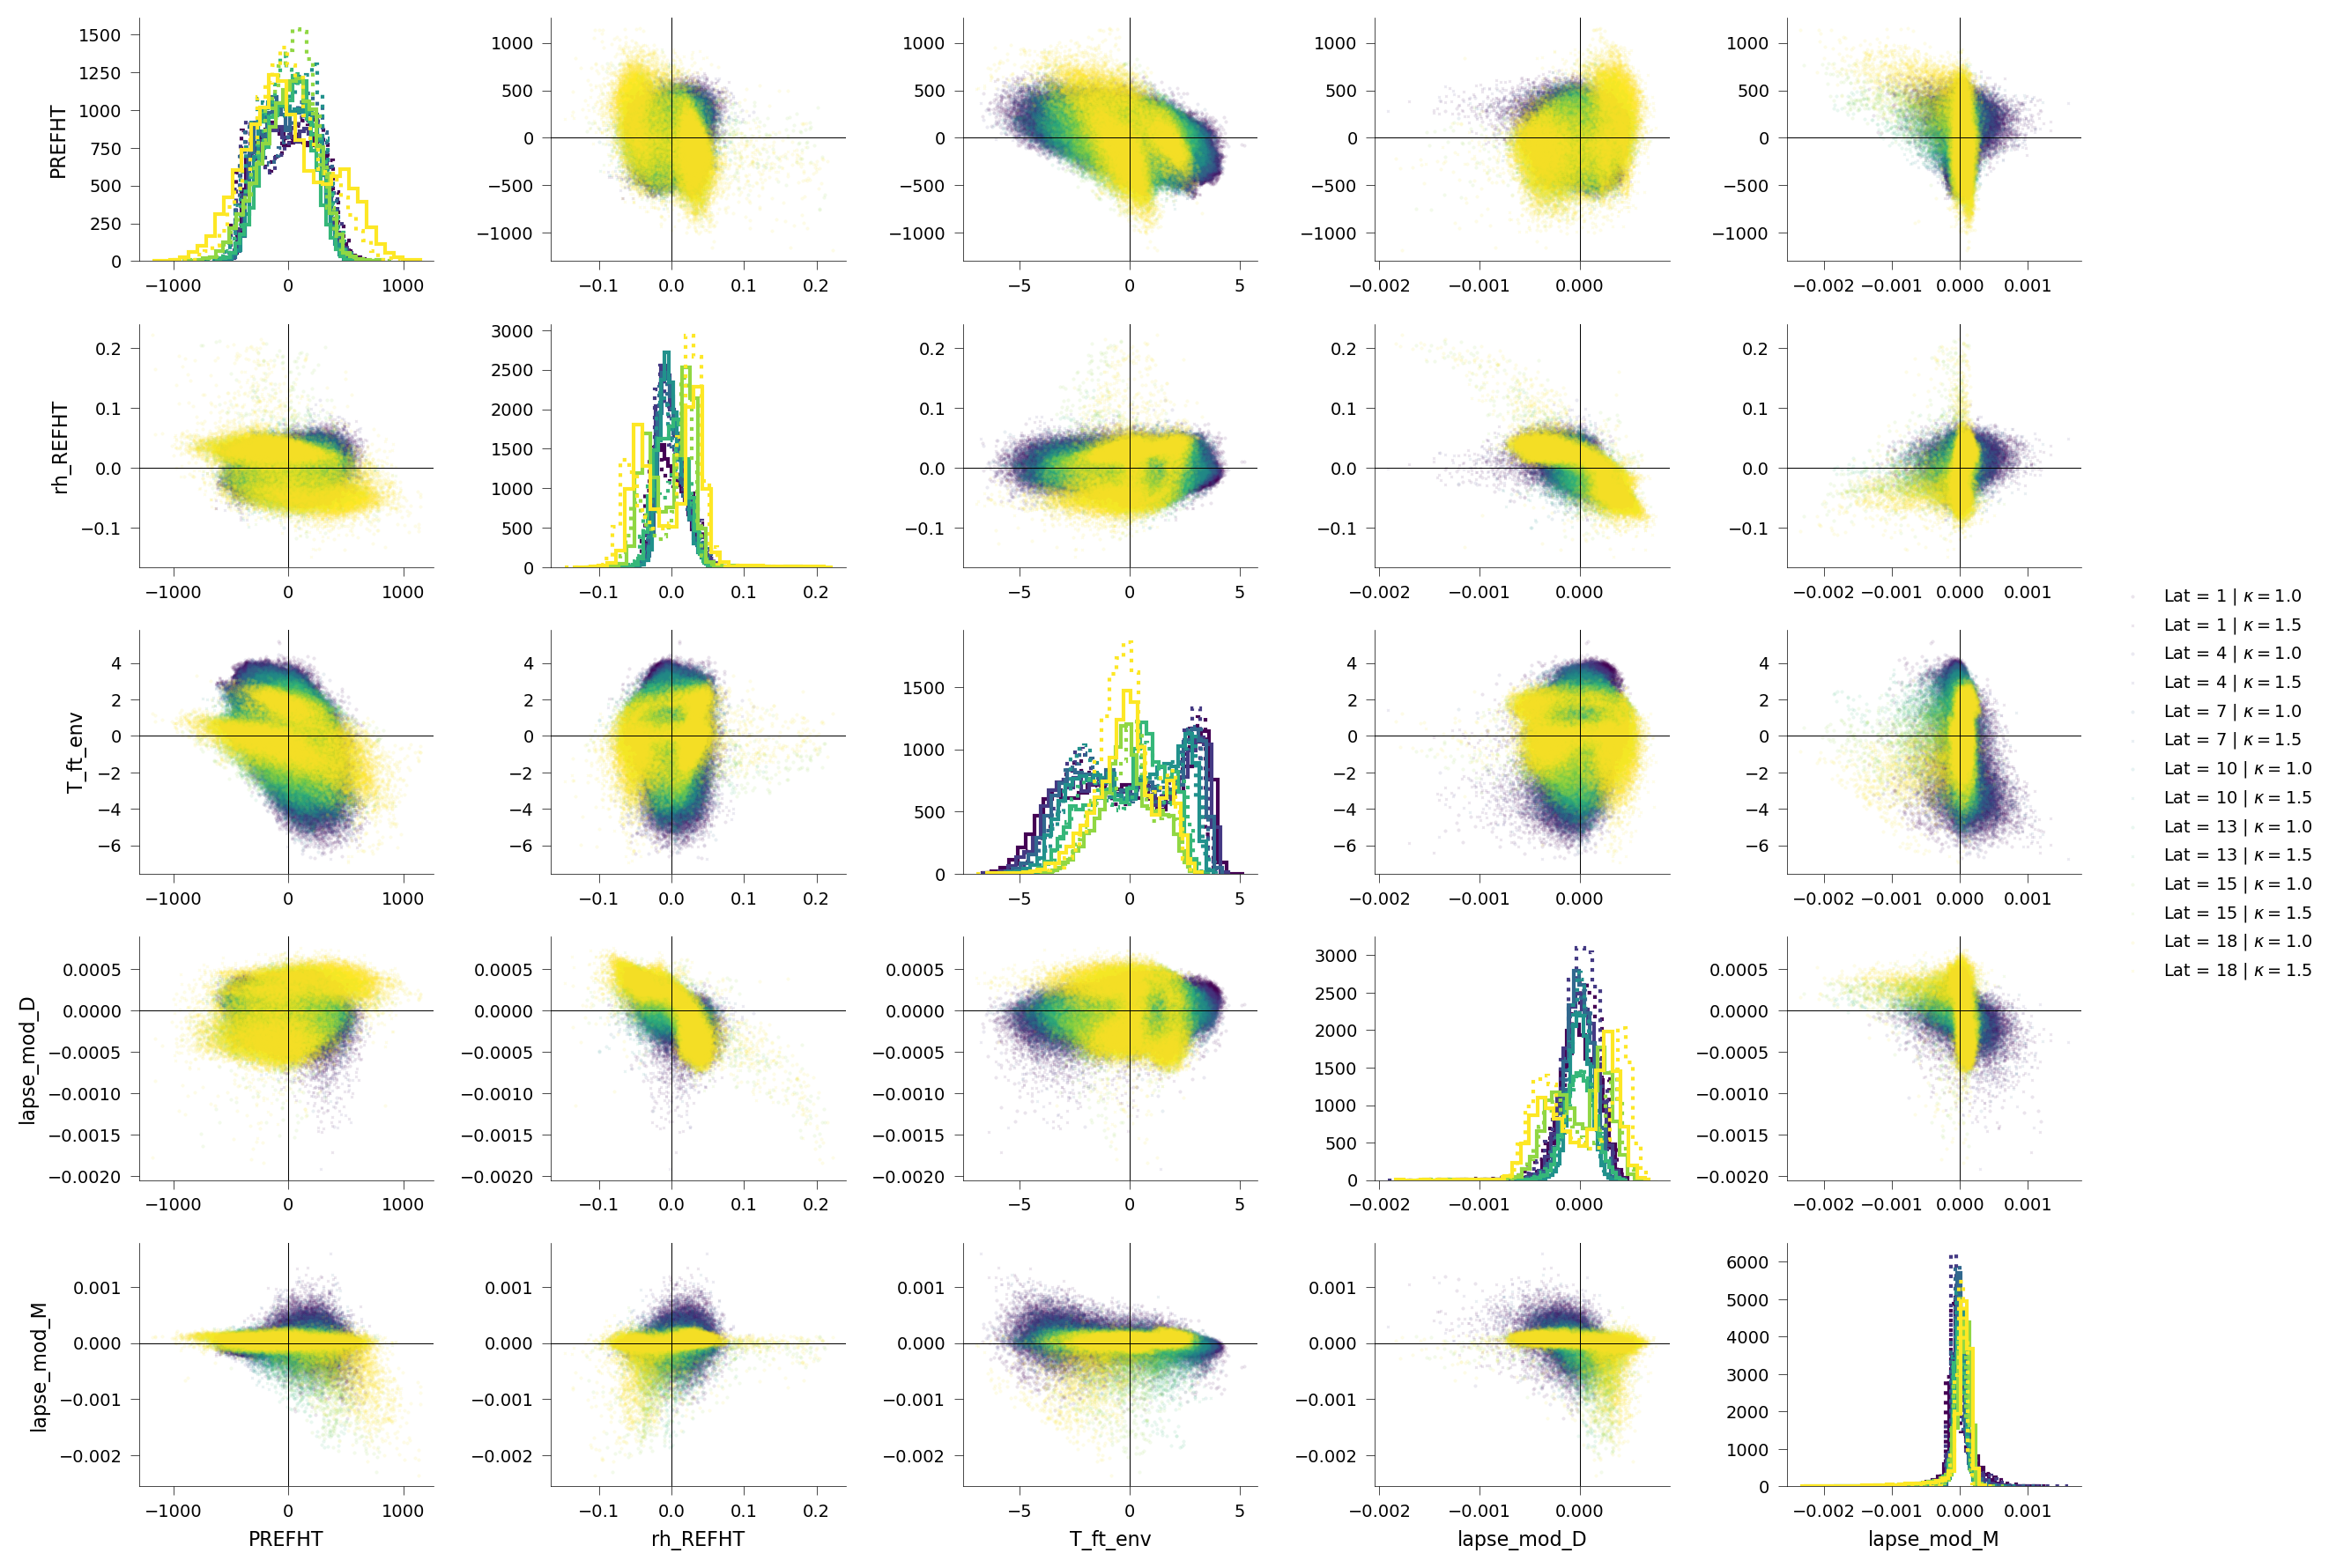

In [29]:
n_var = len(ds_pca.data_vars)
# Unique values for coloring/markers

# Assign colors and markers
colors = plt.cm.viridis(np.linspace(0, 1, len(ds_pca.lat)))
markers = ['.', 'x']  # extend if needed

fig, axes = plt.subplots(n_var, n_var, squeeze=False)
fig_resize(fig, 12)

for i, var_y in enumerate(list(ds_pca.data_vars)):
    for j, var_x in enumerate(list(ds_pca.data_vars)):
        ax = axes[i, j]
        for lat_idx, lat in enumerate(ds_pca.lat):
            for tau_idx, tau in enumerate(ds_pca.tau_lw):
                # Filter data for specific latitude and tau_lw
                x = ds_pca[var_x].where(mask_use).sel(lat=lat, tau_lw=tau)
                y = ds_pca[var_y].where(mask_use).sel(lat=lat, tau_lw=tau)
                if i == j:
                    # Diagonal: histogram line
                    ax.hist(x.values.flatten(), bins=30, color=colors[lat_idx], linestyle=':' if tau_idx == 1 else '-',
                            histtype='step', linewidth=1.5)
                else:
                    ax.scatter(x, y, color=colors[lat_idx], marker=markers[tau_idx],
                               label=f'Lat = {lat:.0f} | $\kappa = {tau:.1f}$', s=1, alpha=0.1)
                    ax.axhline(0, color='k', lw=ax_linewidth)
                    ax.axvline(0, color='k', lw=ax_linewidth)

        if i == n_var - 1:
            ax.set_xlabel(var_x)
        if j == 0:
            ax.set_ylabel(var_y)
        # ax.grid(True)

# Optional: create a single legend
handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center')
plt.tight_layout()
plt.show()

### PC Results
Below I keep the first 3 PCs and plot how surface temperature varies with the PCs, along with the loadings which can be used to understand the surface temperature dependence.

In [661]:
pc_output = pca_on_xarray(xr.concat(list(ds_pca.values()), dim="feature"), n_modes=3, feature_dim_name="feature",
                          valid=mask_use)

In [662]:
def get_temp_surf_from_pc(pc_x_coef, pc_y_coef, pc_eof=pc_output[0], pc_mean=pc_output[2], pc_std=pc_output[3],
                          ds_ref=ds_ref.isel(lat=0, tau_lw=0), pc_x_mode_ind=0, pc_y_mode_ind=2):
    # pc_coef should be n_mode x n_vals
    # pc_eof should be n_mode x n_feature
    # Returns n_pc1_coef x n_pc2_coef
    var = pc_x_coef[:, np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_x_mode_ind).values[np.newaxis, np.newaxis]
    var = var + pc_y_coef[np.newaxis, : np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_y_mode_ind).values[
        np.newaxis, np.newaxis]
    var = var * pc_std.values[np.newaxis, np.newaxis] + pc_mean.values[np.newaxis, np.newaxis]
    # var1 = pc1_coef[:, np.newaxis] * (pc_eof.isel(mode=0) * pc_std).values[np.newaxis]
    # var2 = pc2_coef[:, np.newaxis] * (pc_eof.isel(mode=1) * pc_std).values[np.newaxis]
    # var = var1[:, np.newaxis] + var2[np.newaxis]
    # var = var + pc_mean.values[np.newaxis, np.newaxis]
    p_surf = var[:, :, 0] + float(ds_ref['PREFHT'])
    rh_surf = var[:, :, 1] + float(ds_ref['rh_REFHT'])
    temp_ft_env = var[:, :, 2] + float(ds_ref['T_ft_env'])
    lapse_mod_D = var[:, :, 3] + float(ds_ref['lapse_mod_D'])
    lapse_mod_M = var[:, :, 4] + float(ds_ref['lapse_mod_M'])
    get_temp = np.vectorize(get_temp_mod_parcel)
    return get_temp(rh_surf, p_surf, ds_quant.p_ft, lapse_mod_D, lapse_mod_M, None, temp_ft_env,
                    ds_quant.temp_surf_lcl_calc)

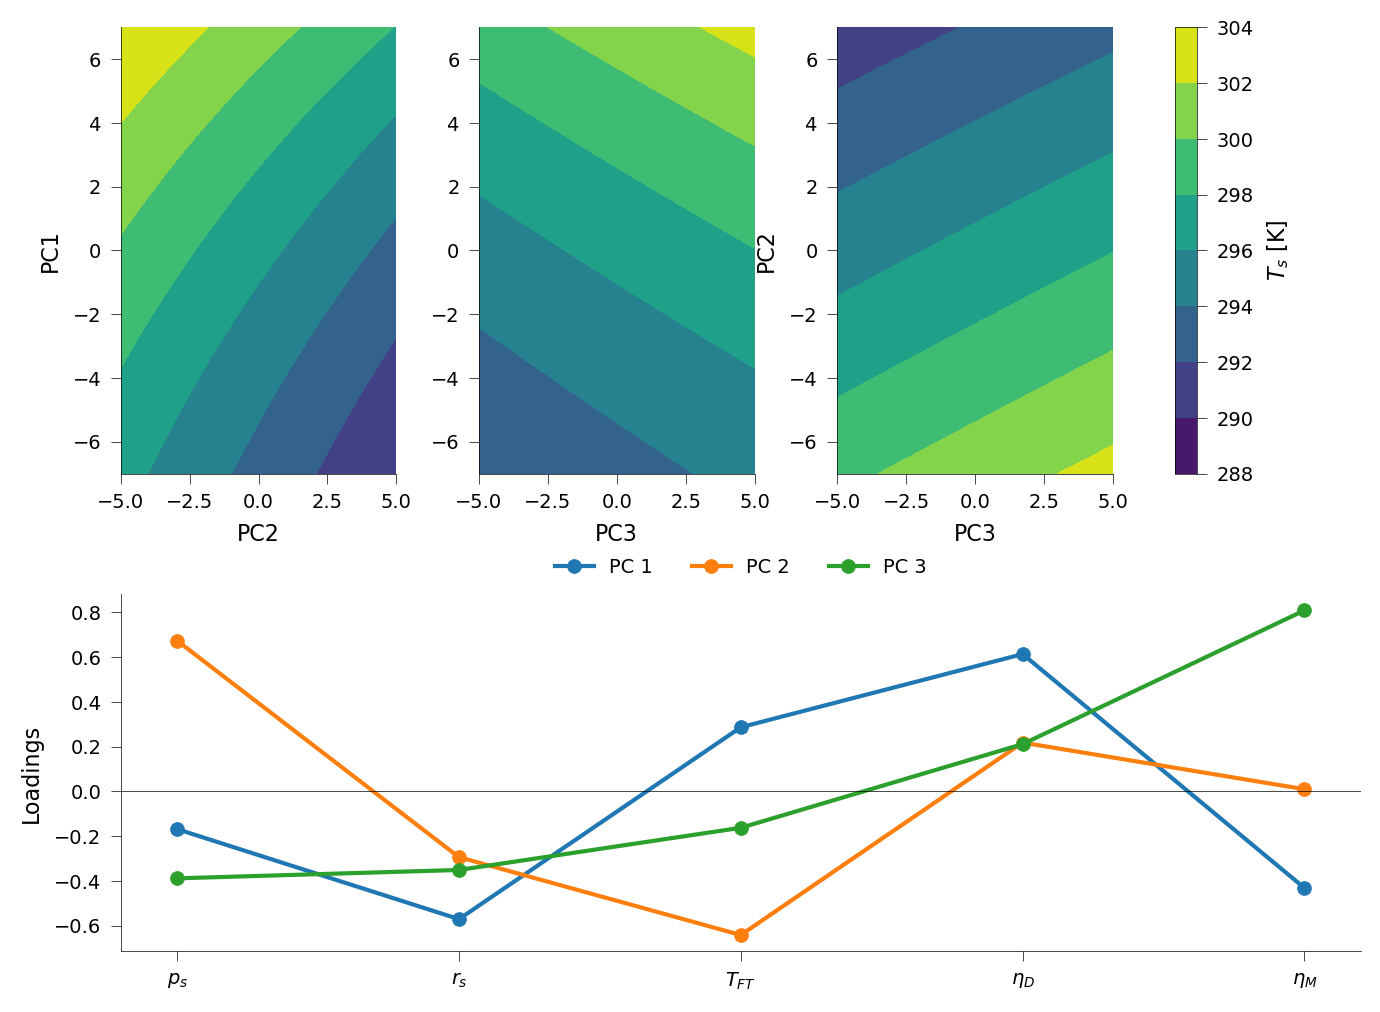

In [663]:
pc_x_coef_plot = np.arange(-5, 5.5, 0.5)
pc_y_coef_plot = np.arange(-7, 7.5, 0.5)

# Generate temperature surfaces
temp_surf_0_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=1, pc_y_mode_ind=0)
temp_surf_2_0 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=0)
temp_surf_2_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=1)

# Use gridspec to span bottom row
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.8], hspace=0.3, wspace=0.3)

# Top row: contour plots
ax0 = fig.add_subplot(gs[0, 0])
fig_resize(fig, 8)
im0 = ax0.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_0_1.T, levels=np.arange(288, 306, 2))
ax0.set_xlabel('PC2')
ax0.set_ylabel('PC1')

ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_0.T, levels=np.arange(288, 306, 2))
ax1.set_xlabel('PC3')

ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_1.T, levels=np.arange(288, 306, 2))
ax2.set_xlabel('PC3')
ax2.set_ylabel('PC2')

# Colorbar for top row
plt.colorbar(im2, ax=[ax0, ax1, ax2], label='$T_s$ [K]')

# Bottom row: single axis spanning all columns
ax_line = fig.add_subplot(gs[1, :])
for mode in range(pc_output[0].mode.size):
    ax_line.plot(np.arange(5), pc_output[0].isel(mode=mode), label=f'PC {mode + 1}', color=f"C{mode}", marker='o',
                 lw=1.5, markersize=5)
ax_line.set_xticks(np.arange(pc_output[0].feature.size))
ax_line.set_xticklabels(['$p_s$', '$r_s$', '$T_{FT}$', '$\eta_D$', '$\eta_M$'])
ax_line.set_ylabel('Loadings')
ax_line.legend(ncol=3, bbox_to_anchor=(0.5, 1.00), loc='lower center')
ax_line.axhline(0, color='k', lw=ax_linewidth)
plt.show()


In [664]:
ds_quant_sl = ds_quant.isel(lat=-1, surf=0)
# ds_quant_sl['cluster_ind'] = cluster_ind.sel(lat=ds_quant_sl['lat'])
ds_quant_sl['pc_coef'] = pc_output[1].sel(lat=ds_quant_sl['lat'])
for key in ds_pca:
    ds_quant_sl[key] = ds_pca[key].sel(lat=ds_quant_sl['lat'])
for key in ds_ref:
    ds_quant_sl[f"{key}_ref"] = ds_ref[key].sel(lat=ds_quant_sl['lat'])

In [665]:
def get_temp_surf_from_pc_xr(pc_coef, pc_eof, ds_ref, pc_mean=pc_output[2], pc_std=pc_output[3],
                             p_ft=ds_quant_sl.p_ft, temp_surf_lcl_calc=ds_quant.temp_surf_lcl_calc,
                             var_manual=None):
    var = (pc_coef * pc_eof).sum(dim='mode')
    var = var * pc_std + pc_mean

    var_dict = {}
    for i, key in enumerate(['PREFHT', 'rh_REFHT', 'T_ft_env', 'lapse_mod_D', 'lapse_mod_M']):
        var_dict[key] = var.isel(feature=i) + ds_ref[f"{key}_ref"]
    if var_manual:
        for key in var_manual:
            var_dict[key] = var_manual[key]
    return get_temp_mod_parcel_xr(var_dict['rh_REFHT'], var_dict['PREFHT'], p_ft, var_dict['lapse_mod_D'],
                                  var_dict['lapse_mod_M'],
                                  None, var_dict['T_ft_env'], temp_surf_lcl_calc)

In [666]:
TREFHT_recon = {}
var_recon_list = ['PREFHT', 'rh_REFHT', 'T_ft_env', 'lapse_mod_D', 'lapse_mod_M']
with tqdm(total=len(var_recon_list) * 2 + 3, position=0, leave=True) as pbar:
    for i in range(3):
        TREFHT_recon[f'PC{i + 1}'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, i)),
                                                              pc_output[0].sel(mode=slice(0, i)), ds_quant_sl)
        pbar.update(1)
    for i, key in enumerate(var_recon_list):
        TREFHT_recon[key] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)),
                                                     pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
                                                     var_manual={key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"]})
        pbar.update(1)
        TREFHT_recon[key + '_noPC'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)) * 0,
                                                               pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
                                                               var_manual={
                                                                   key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"]})
        pbar.update(1)
TREFHT_recon = xr.Dataset(TREFHT_recon)

  0%|          | 0/13 [00:00<?, ?it/s]

In [668]:
def select_closest_feature(data: xr.DataArray, target: xr.DataArray, min_dim='feature'):
    diff = abs(data - target)
    idx = diff.argmin(dim=min_dim)
    return data.isel(feature=idx), idx


TREFHT_recon['best'], TREFHT_recon['cluster_idx'] = \
    select_closest_feature(xr.concat(list(TREFHT_recon[var_recon_list].values()), dim="feature"), ds_quant_sl.TREFHT)

TREFHT_recon['best_noPC'], TREFHT_recon['cluster_idx_noPC'] = \
    select_closest_feature(
        xr.concat(list(TREFHT_recon[[f"{key}_noPC" for key in var_recon_list]].values()), dim="feature"),
        ds_quant_sl.TREFHT)
# Just assume ref values for each day - idea of worst possible approximation
TREFHT_recon['ref'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)).isel(quant=0, sample=0) * 0,
                                               pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl)

# Sanity check that this matches exactly
# TREFHT_recon['exact'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)),
#                                                  pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
#                                                  var_manual={
#                                                      key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"] for key in var_recon_list})

In [669]:
with tqdm(total=len(var_recon_list)**2 - len(var_recon_list), position=0, leave=True) as pbar:
    for i, key in enumerate(var_recon_list):
        for j, key2 in enumerate(var_recon_list):
            if i == j:
                continue
            TREFHT_recon[key+'_'+key2+'_nl'] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)) * 0,
                                                                   pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
                                                                   var_manual={
                                                                       key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"],
                                                                       key2: ds_quant_sl[key2] + ds_quant_sl[f"{key2}_ref"]})
            pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

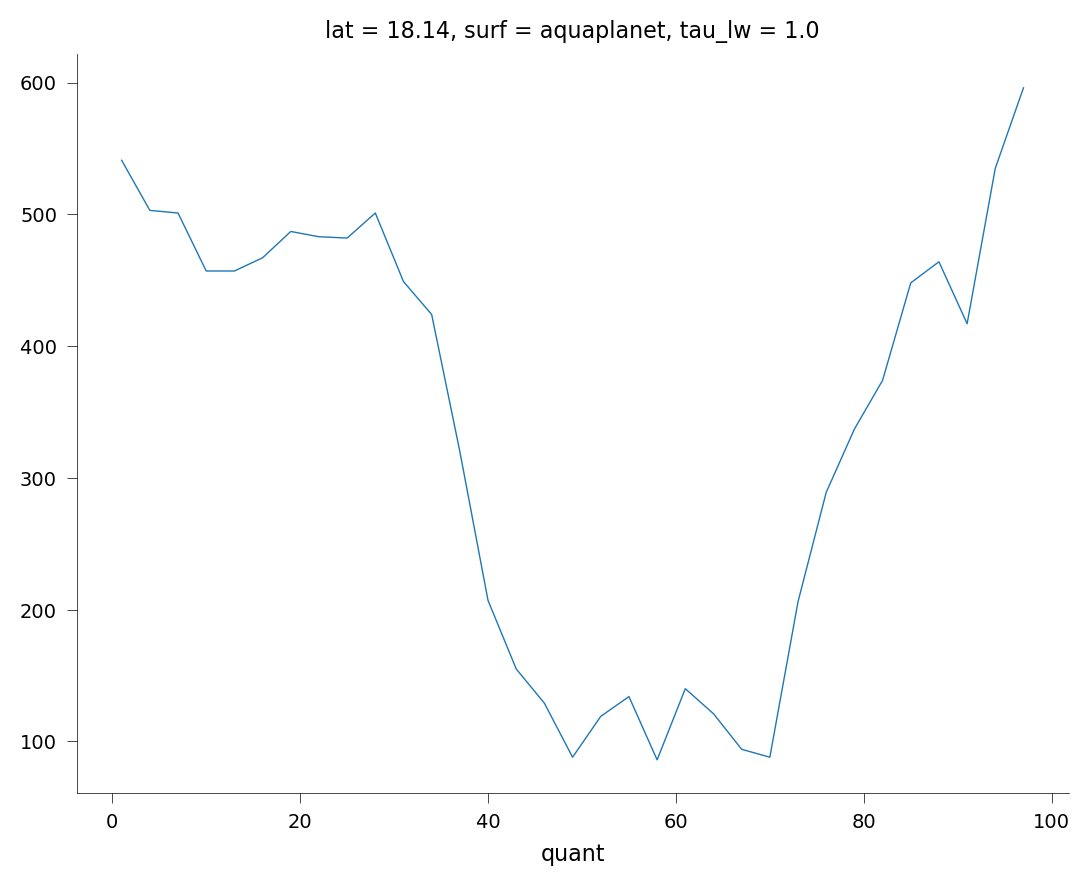

In [749]:
(np.abs(TREFHT_recon['best_nl'] - TREFHT_recon['best_noPC'])>float(ds_quant_sl.TREFHT.mean(dim='sample').diff(dim='quant').mean())).sum(dim='sample').isel(tau_lw=0).plot()

In [759]:
TREFHT_recon['best_nl'], TREFHT_recon['cluster_idx_nl'] = \
    select_closest_feature(
        xr.concat(list(TREFHT_recon[[key for key in TREFHT_recon if 'nl' in key]].values()), dim="feature"),
        ds_quant_sl.TREFHT)
temp_diff_thresh = 0.3
change_cond = np.abs(TREFHT_recon['best_nl'] - TREFHT_recon['best_noPC']) > temp_diff_thresh
TREFHT_recon['best_nl'] = TREFHT_recon['best_nl'].where(change_cond, TREFHT_recon['best_noPC'])
TREFHT_recon['cluster_idx_nl'] = TREFHT_recon['cluster_idx_nl'].where(change_cond, -TREFHT_recon['cluster_idx_noPC']-1)

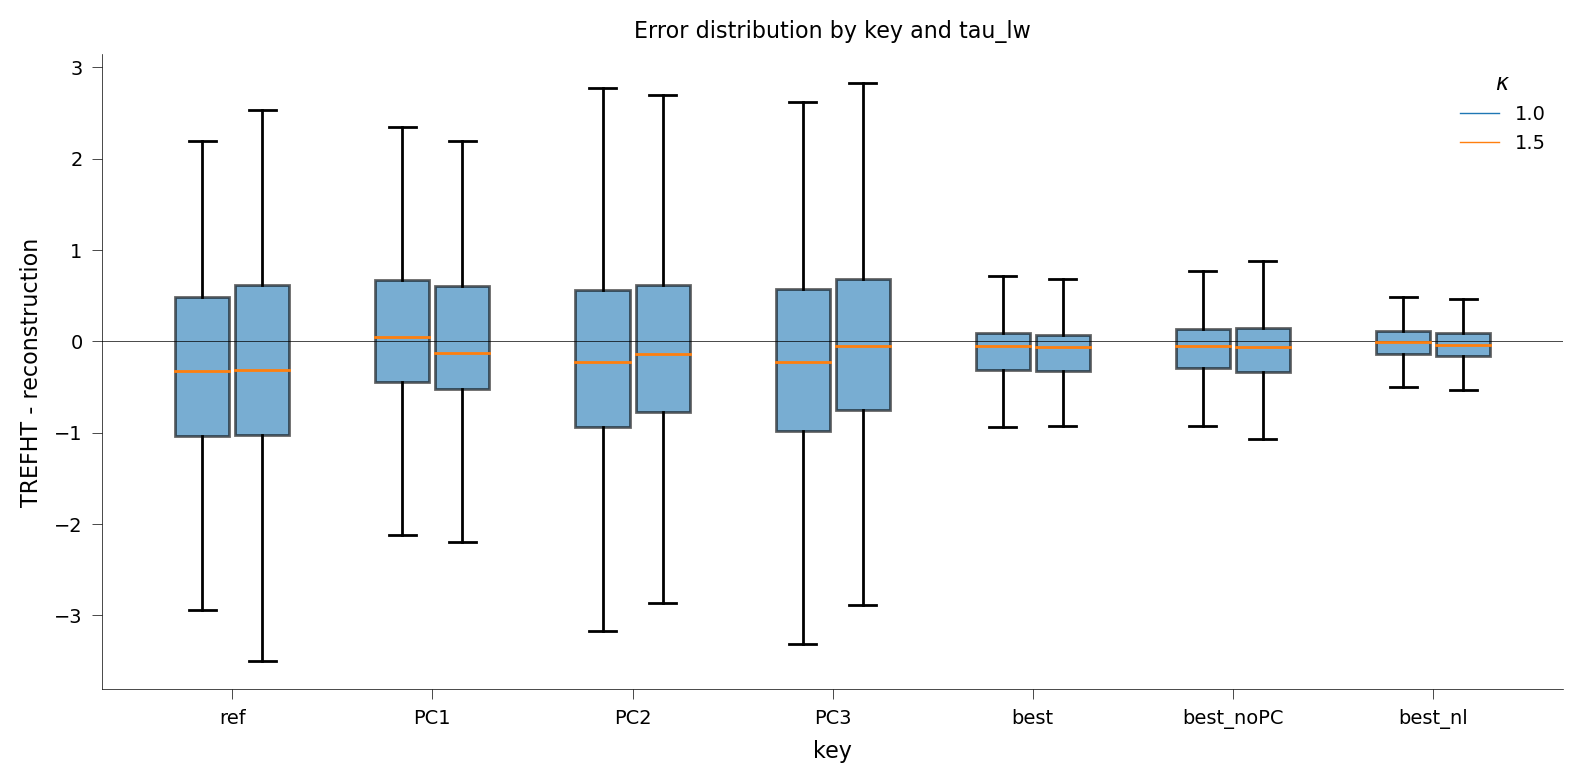

In [760]:
import matplotlib.pyplot as plt
import numpy as np

keys = ['ref', 'PC1', 'PC2', 'PC3', 'best', 'best_noPC', 'best_nl']
tau_vals = ds_quant_sl.tau_lw.values
n_keys = len(keys)
n_tau = len(tau_vals)

# Collect data in a 2D list: data[key][tau]
all_data = []
for key in keys:
    key_data = []
    for i in range(n_tau):
        arr = (ds_quant_sl.TREFHT - TREFHT_recon[key]).isel(tau_lw=i).values.flatten()
        key_data.append(arr)
    all_data.append(key_data)

# Plot
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 8, ar=2)
group_width = 0.6
box_width = group_width / n_tau
x_base = np.arange(n_keys)

for j in range(n_tau):
    positions = x_base - group_width / 2 + j * box_width + box_width / 2
    ax.boxplot(
        [all_data[i][j] for i in range(n_keys)],
        positions=positions,
        widths=box_width * 0.9,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(alpha=0.6)
    )

# X labels
ax.set_xticks(x_base)
ax.set_xticklabels(keys)

ax.set_xlabel("key")
ax.set_ylabel("TREFHT - reconstruction")
ax.set_title("Error distribution by key and tau_lw")

# Legend
legend_labels = [f"{v:.1f}" for v in tau_vals]
for j in range(n_tau):
    ax.plot([], [], label=legend_labels[j])
ax.legend(title="$\kappa$")
ax.axhline(0, color="k", lw=ax_linewidth)

plt.tight_layout()
plt.show()

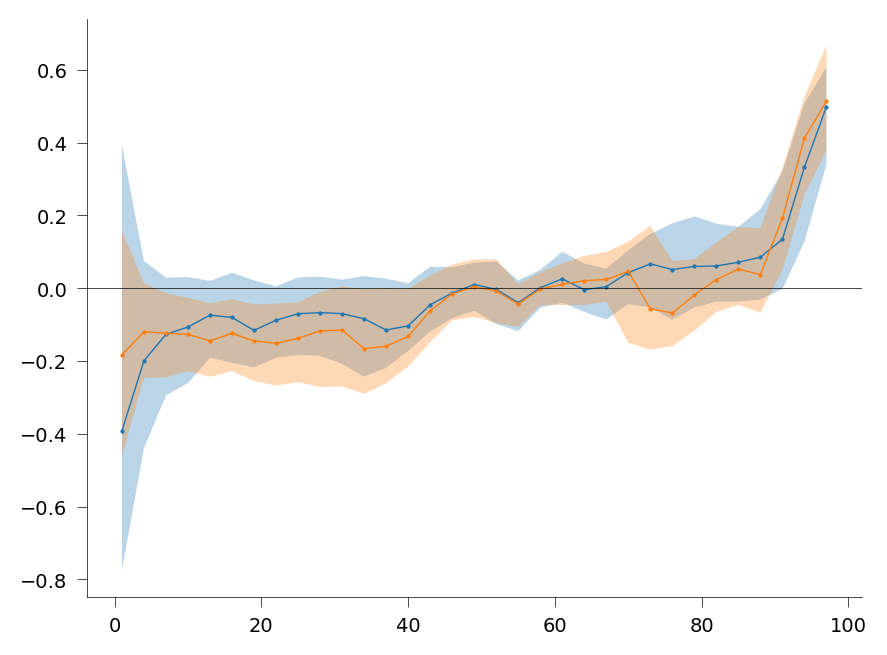

In [761]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)
for i in range(n_tau):
    var = (ds_quant_sl.TREFHT - TREFHT_recon['best_nl']).isel(tau_lw=i)
    ax.plot(ds_quant_sl.quant, var.quantile(0.5, dim='sample'), marker='.')
    ax.fill_between(ds_quant_sl.quant, var.quantile(0.25, dim='sample'), var.quantile(0.75, dim='sample'),
                    alpha=0.3)
ax.axhline(0, color="k", lw=ax_linewidth)
plt.show()

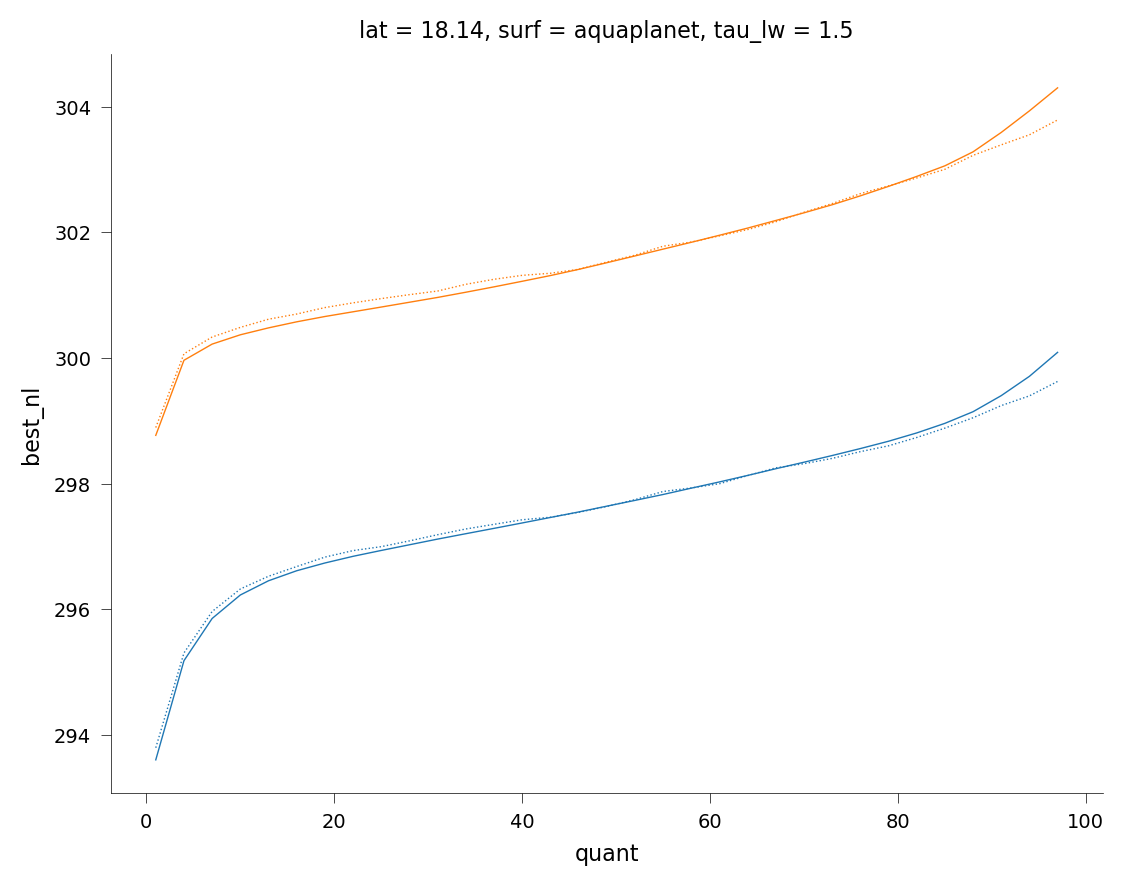

In [762]:
for i in range(n_tau):
    ds_quant_sl.TREFHT.isel(tau_lw=i).mean(dim='sample').plot(color=f"C{i}")
    TREFHT_recon['best_nl'].isel(tau_lw=i).mean(dim='sample').plot(color=f"C{i}", linestyle=':')

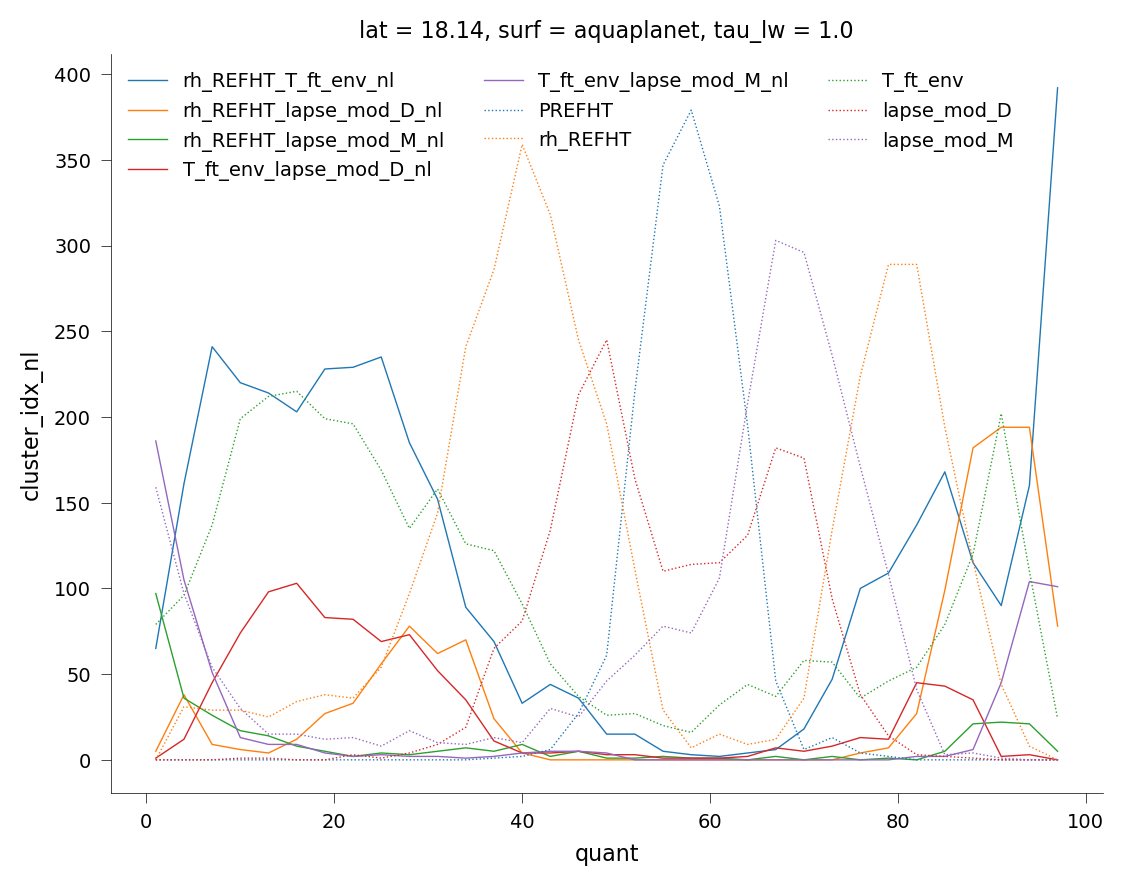

In [775]:
j = 0
for i, key in enumerate([key for key in TREFHT_recon if 'nl' in key]):
    var = (TREFHT_recon['cluster_idx_nl']==i).sum(dim='sample')
    if var.max() < 50:
        continue
    var.isel(tau_lw=j).plot(label=key)
for i, key in enumerate(var_recon_list):
    var = (TREFHT_recon['cluster_idx_nl']==-i-1).sum(dim='sample')
    if var.max() < 50:
        continue
    var.isel(tau_lw=j).plot(label=key, color=f"C{i}", linestyle=':')
plt.legend(ncol=3)

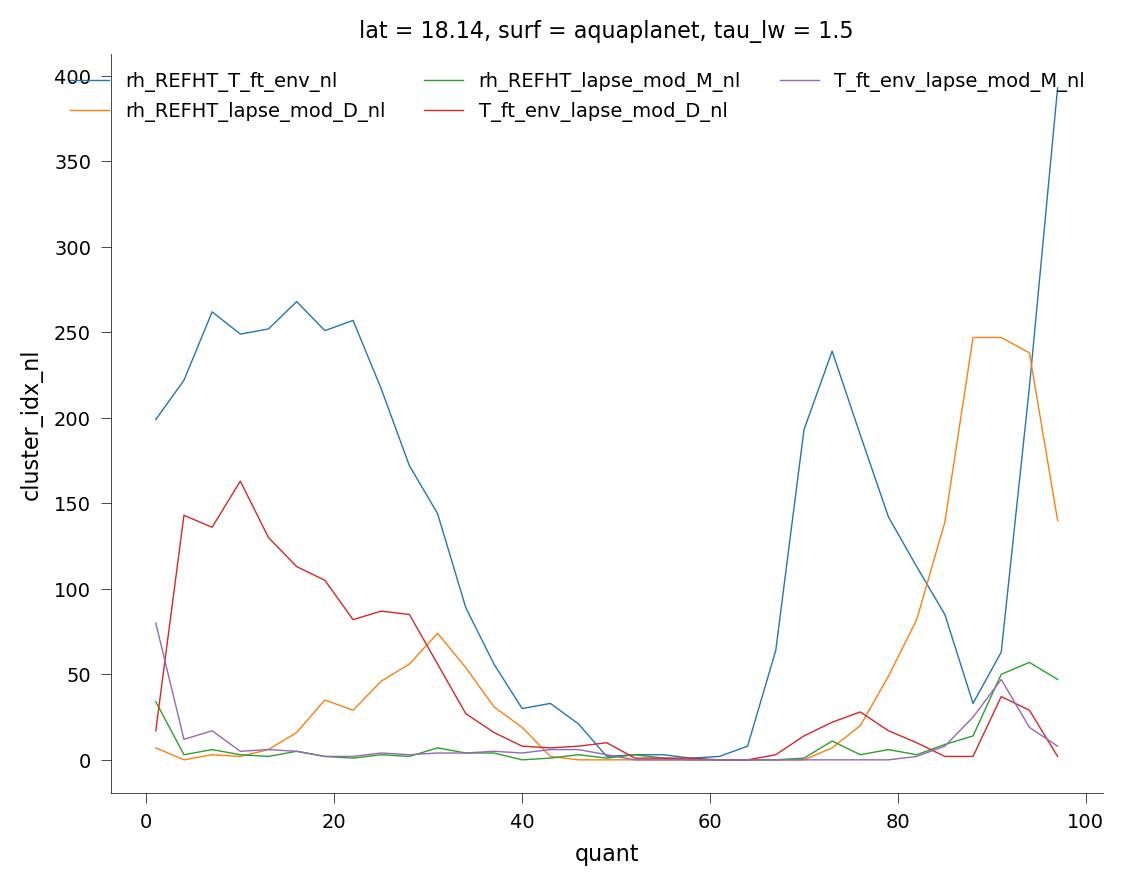

In [764]:
for i, key in enumerate([key for key in TREFHT_recon if 'nl' in key]):
    var = (TREFHT_recon['cluster_idx_nl']==i).sum(dim='sample')
    if var.max() < 50:
        continue
    var.isel(tau_lw=1).plot(label=key)
plt.legend(ncol=3)

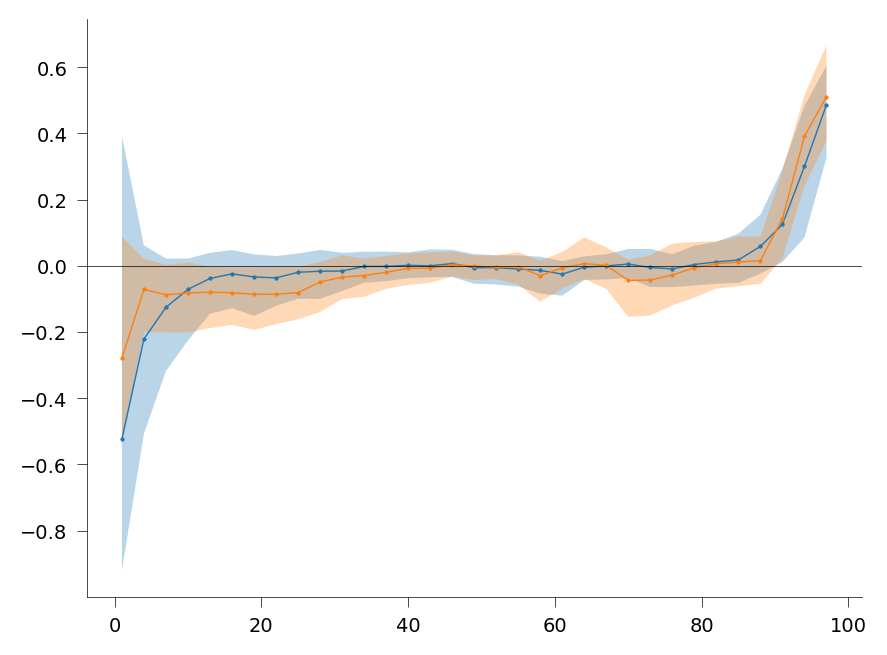

In [708]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)
for i in range(n_tau):
    var = (ds_quant_sl.TREFHT - TREFHT_recon['best_nl']).isel(tau_lw=i)
    ax.plot(ds_quant_sl.quant, var.quantile(0.5, dim='sample'), marker='.')
    ax.fill_between(ds_quant_sl.quant, var.quantile(0.25, dim='sample'), var.quantile(0.75, dim='sample'),
                    alpha=0.3)
ax.axhline(0, color="k", lw=ax_linewidth)
plt.show()

In [632]:
import numpy as np
from typing import Callable, Tuple


def golden_section_minimize_scalar(
        g: Callable[[float], float],
        a: float,
        b: float,
        tol: float = 1e-5,
        max_iter: int = 60
) -> float:
    """Simple golden-section search (minimize scalar function on [a,b])."""
    gr = (np.sqrt(5) - 1) / 2  # golden ratio conjugate ~0.618
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = g(c)
    fd = g(d)
    it = 0
    while it < max_iter and (b - a) > tol:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - gr * (b - a)
            fc = g(c)
        else:
            a, c, fc = c, d, fd
            d = a + gr * (b - a)
            fd = g(d)
        it += 1
    return 0.5 * (a + b)


def fit_direction_alternating(
        f_np: Callable[[np.ndarray], np.ndarray],
        A: np.ndarray,
        v_init: np.ndarray,
        X_std: np.ndarray,
        X_mean: np.ndarray,
        lambdas_init: Optional[np.ndarray] = None,
        n_outer: int = 20,
        lambda_bounds: Tuple[float, float] = (-5.0, 5.0),
) -> Tuple[np.ndarray, np.ndarray]:
    """Alternating optimization: find v and per-sample lambdas for black-box f.

    Args:
        f_np: black-box function mapping array X_in of shape (M, P) -> (M, D_out).
        A: numpy array (N, D_out) targets.
        P: ambient dimension (length of v).
        n_outer: number of alternating iterations.
        lambda_bounds: bounds (min, max) for scalar search.
        v_init: optional initial vector shape (P,).

    Returns:
        v: unit-norm vector shape (P,).
        lambdas: array shape (N,) of per-sample scalars.
    """
    N = A.shape[0]
    P = v_init.shape[0]
    v_norm = np.linalg.norm(v_init) + 1e-12
    v = v_init / v_norm

    # initialize lambdas from projecting X if available; otherwise zeros
    if lambdas_init is None:
        lambdas = np.zeros(N, dtype=float)
    else:
        lambdas = lambdas_init * v_norm

    for outer in range(n_outer):
        # 1) For fixed v, find each lambda_i via 1-D search
        def make_loss_for_i(i):
            Ai = A[i:i + 1]  # shape (1, )

            def loss_of_lambda(lmb):
                x = (lmb * v).reshape(1, -1)  # (1, P)
                pred = f_np(x * X_std + X_mean)  # (1, D_out)
                # mean squared error over output dims
                return float(np.mean((pred - Ai) ** 2))

            return loss_of_lambda

        for i in range(N):
            g = make_loss_for_i(i)
            # search within bounds
            lam_star = golden_section_minimize_scalar(g, lambda_bounds[0], lambda_bounds[1], tol=1e-4, max_iter=50)
            lambdas[i] = lam_star

        # 2) For fixed lambdas, update v.
        # If f_np is differentiable and you can provide a gradient, use it.
        # Here we approximate gradient by finite differences (good for modest P).
        # Objective: sum_i || f_np(lambdas[i]*v) - A_i ||^2
        eps = 1e-6
        X_stack = (lambdas.reshape(-1, 1) * v.reshape(1, -1))  # (N, P)
        preds = f_np(X_stack * X_std + X_mean)  # (N, D_out)
        obj0 = float(np.sum((preds - A) ** 2))

        # compute gradient approx
        grad = np.zeros_like(v)
        for p in range(P):
            v_p_plus = v.copy()
            v_p_plus[p] += eps
            Xp = (lambdas.reshape(-1, 1) * v_p_plus.reshape(1, -1))
            predp = f_np(Xp * X_std + X_mean)
            objp = float(np.sum((predp - A) ** 2))
            grad[p] = (objp - obj0) / eps

        # take a simple gradient step with backtracking style learning rate
        # scale step small enough to keep stable
        step = 1e-3 / (np.linalg.norm(grad) + 1e-12)
        v = v - step * grad
        v /= (np.linalg.norm(v) + 1e-12)

        # optional progress
        print(f"outer {outer + 1}/{n_outer}, obj {obj0:.6e}")

    return v, lambdas


In [633]:
ds_use = ds_quant_sl.isel(tau_lw=0, quant=0)
X_mean_use = xr.concat(list(ds_use[[f"{key}_ref" for key in var_recon_list]].values()), dim="feature").values + \
             pc_output[2].values
var = fit_direction_alternating(get_temp_surf_from_X, ds_use.TREFHT.values, pc_output[0].isel(mode=0).values,
                                pc_output[3].values,
                                X_mean_use, lambdas_init=ds_use.pc_coef.isel(mode=0).values)

outer 1/20, obj 2.722641e+03
outer 2/20, obj 2.706035e+03
outer 3/20, obj 2.689491e+03
outer 4/20, obj 2.673009e+03
outer 5/20, obj 2.656588e+03
outer 6/20, obj 2.640230e+03
outer 7/20, obj 2.623933e+03
outer 8/20, obj 2.607698e+03
outer 9/20, obj 2.591525e+03
outer 10/20, obj 2.575413e+03
outer 11/20, obj 2.559363e+03
outer 12/20, obj 2.543374e+03
outer 13/20, obj 2.527447e+03
outer 14/20, obj 2.511581e+03
outer 15/20, obj 2.495776e+03
outer 16/20, obj 2.480032e+03
outer 17/20, obj 2.464349e+03
outer 18/20, obj 2.448727e+03
outer 19/20, obj 2.433166e+03
outer 20/20, obj 2.417666e+03


In [635]:
pc_output[0].isel(mode=0).values

array([-0.16922452, -0.57148443,  0.28622818,  0.61329121, -0.43210638])

In [634]:
var[0]

array([-0.1668072 , -0.57203613,  0.30285138,  0.61174206, -0.42308713])

In [629]:
get_temp_vect = np.vectorize(get_temp_mod_parcel)


def get_temp_surf_from_X(X, p_ft=ds_quant.p_ft, temp_surf_lcl_calc=ds_quant.temp_surf_lcl_calc):
    return get_temp_vect(X[:, 1], X[:, 0], p_ft, X[:, 3], X[:, 4], None, X[:, 2],
                         temp_surf_lcl_calc)


def f_wrapper(X_torch):
    """Convert torch tensor → numpy → f → torch tensor."""
    X_np = X_torch.detach().cpu().numpy()
    out_np = get_temp_surf_from_X(X_np)
    return torch.tensor(out_np, dtype=torch.float32)


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Callable, Optional, Tuple


def fit_projection_single_dim(
        v_init: np.ndarray,
        A: np.ndarray,
        f: Callable[[torch.Tensor], torch.Tensor],
        X_std: np.ndarray,
        X_mean_init: np.ndarray,
        lambdas_init: Optional[np.ndarray] = None,
        n_epochs: int = 1500,
        lr: float = 1e-2,
        verbose: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """Fit v (projection direction) and λ_i such that f(λ_i v) ≈ A.

    Args:
        X: Input array of shape (N, P), each row a sample.
        A: Target array of shape (N,), one float per sample.
        f: Callable taking a tensor X_in of shape (N, P) and returning
           tensor of shape (N,) or (N,1). This is the *true* mapping.
        n_epochs: Number of gradient steps.
        lr: Learning rate.
        v_init: Optional initial direction, shape (P,). If None, random init.
        verbose: Whether to print loss during training.

    Returns:
        v: Unit-norm direction, numpy array of shape (P,).
        lambdas: Numpy array of shape (N,) giving optimal λ_i.

    Notes:
        - X shape: (N, P)
        - X_std shape: (P,)
        - X_mean shape: (P,)
        - A shape: (N,)
        - v shape: (P,)
        - lambdas shape: (N,)
        - f is applied at each iteration to batch of shape (N, P)
    """
    # Convert to tensors
    A_t = torch.tensor(A.reshape(-1, 1), dtype=torch.float32)  # (N, 1)
    N = A_t.shape[0]

    # Initialise v
    v0 = v_init.astype(np.float32)
    v0_norm = np.linalg.norm(v0) + 1e-12
    v0 = v0 / v0_norm

    v = torch.tensor(v0, dtype=torch.float32, requires_grad=True)  # (P,)
    P = v.shape[0]

    X_std_t = torch.tensor(X_std, dtype=torch.float32)  # (P,)
    X_mean_t = torch.tensor(X_mean_init, dtype=torch.float32)  # (P,)

    # Initialise lambdas per sample
    if lambdas_init is None:
        lambdas = torch.zeros((N, 1), dtype=torch.float32, requires_grad=True)

    else:
        lambdas = v0_norm * lambdas_init  # account for normalization done to v0
        lambdas = torch.tensor(lambdas.reshape(-1, 1), dtype=torch.float32, requires_grad=True)  # (N, 1)

    # Optimiser
    opt = optim.Adam([v, lambdas], lr=lr)

    for epoch in range(1, n_epochs + 1):
        opt.zero_grad()

        # ensure v stays unit norm (project before use)
        v_norm = v / (v.norm() + 1e-12)

        # form new inputs: X'_i = λ_i v_norm
        X_new = lambdas * v_norm.unsqueeze(0)  # (N, 1) * (1, P) -> (N, P)

        # evaluate your *real* function f
        A_hat = f(X_new * X_std_t + X_mean_t)  # expected (N,) or (N,1)
        if A_hat.ndim == 1:
            A_hat = A_hat.unsqueeze(1)
        loss = torch.mean((A_hat - A_t) ** 2)
        loss.backward()
        opt.step()

        # renormalise v after update
        with torch.no_grad():
            v /= (v.norm() + 1e-12)

        if verbose and (epoch % 200 == 0 or epoch == 1):
            print(f"epoch {epoch:4d}  loss={loss.item():.6e}")

    v_final = v.detach().cpu().numpy()
    lambdas_final = lambdas.detach().cpu().numpy().reshape(-1)

    return v_final, lambdas_final


In [630]:
ds_use = ds_quant_sl.isel(tau_lw=0, quant=0)
X_mean_use = xr.concat(list(ds_use[[f"{key}_ref" for key in var_recon_list]].values()), dim="feature").values + \
             pc_output[2].values
var = fit_projection_single_dim(pc_output[0].isel(mode=0).values, ds_use.TREFHT.values, f_wrapper, pc_output[3].values,
                                X_mean_use, lambdas_init=ds_use.pc_coef.isel(mode=0).values, verbose=True)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [601]:
ds_use

<xarray.Dataset> Size: 360kB
Dimensions:               (lev: 25, sample: 600, layer: 2, mode: 3)
Coordinates:
    time                  (sample) float64 5kB 844.5 846.5 ... 2.282e+03
    lon                   (sample) float64 5kB 0.0 0.0 0.0 ... 174.4 174.4 174.4
  * lev                   (lev) float64 200B 4.329 15.55 25.36 ... 983.8 994.9
    lat                   float64 8B 18.14
    surf                  <U10 40B 'aquaplanet'
    tau_lw                float64 8B 1.0
    quant                 int64 8B 1
  * sample                (sample) int64 5kB 0 1 2 3 4 5 ... 595 596 597 598 599
  * mode                  (mode) int64 24B 0 1 2
Dimensions without coordinates: layer
Data variables: (12/25)
    T                     (lev, sample) float32 60kB 218.7 218.1 ... 294.0 293.4
    QREFHT                (sample) float32 2kB 0.009248 0.009028 ... 0.009276
    Z3                    (lev, sample) float32 60kB 3.646e+04 ... 44.21
    CAPE                  (sample) float32 2kB 21.35 10.38 72.29 ... 48.29 37.0
    PS                    (sample) float32 2kB 1.001e+05 1.001e+05 ... 1.004e+05
    hybm                  (lev, sample) float64 120kB 0.005883 ... 0.9949
    ...                    ...
    PREFHT_ref            float64 8B 9.922e+04
    rh_REFHT_ref          float64 8B 0.6543
    T_ft_env_ref          float64 8B 265.1
    lapse_mod_D_ref       float64 8B -0.0006338
    lapse_mod_M_ref       float64 8B 0.0001732
    TREFHT_ref            float32 4B 298.0
Attributes:
    filename:              /sharedscratch/jamd1/isca_work/experiment/tau_swee...
    title:                 FMS Model results
    grid_type:             regular
    grid_tile:             N/A
    n_lev_above_integral:  3
    temp_surf_lcl_calc:    300.0
    p_ft:                  50000
    region:                tropics
    hemisphere:            north
    season:                summer
    exp_dir:               {'aquaplanet': 'tau_sweep/aquaplanet/depth=1/'}

In [453]:
def cluster_pcs(pcs: xr.DataArray, n_clusters: int, mask: xr.DataArray = None) -> xr.DataArray:
    """Cluster PCA coefficients and return cluster labels for each sample.

    Args:
        pcs: PCA coefficients with dims (quant, tau_lw, lat, sample, mode).
        n_clusters: Number of clusters.

    Returns:
        DataArray of cluster labels with dimension 'sample'.
    """
    pcs_stacked = pcs.stack(point=("quant", "tau_lw", "lat", "sample"))
    if mask is not None:
        mask_stacked = mask.stack(point=("quant", "tau_lw", "lat", "sample"))
        # Select only valid points
        X_train = pcs_stacked.sel(point=mask_stacked).transpose("point", "mode").values
    else:
        X_train = pcs_stacked.transpose("point", "mode").values

    # Fit K-means on masked data only
    km = KMeans(n_clusters=n_clusters, n_init="auto")
    km.fit(X_train)

    X_full = pcs_stacked.transpose("point", "mode").values
    # assign clusters using all features
    labels = km.fit_predict(X_full)
    # unflatten_from_numpy(labels, pcs.isel(mode=0))
    return unflatten_from_numpy(labels, pcs.isel(mode=0))


n_clusters = 3
# cluster_ind = cluster_pcs(pc_output[1], n_clusters, mask_use)
cluster_ind = cluster_pcs(pc_output[1].sel(mode=slice(0, 2)), n_clusters)

In [454]:
ds_quant_sl = ds_quant.isel(lat=-1)
ds_quant_sl['cluster_ind'] = cluster_ind.sel(lat=ds_quant_sl['lat'])
ds_quant_sl['pc_coef'] = pc_output[1].sel(lat=ds_quant_sl['lat'])
for key in ds_pca:
    ds_quant_sl[key] = ds_pca[key].sel(lat=ds_quant_sl['lat'])

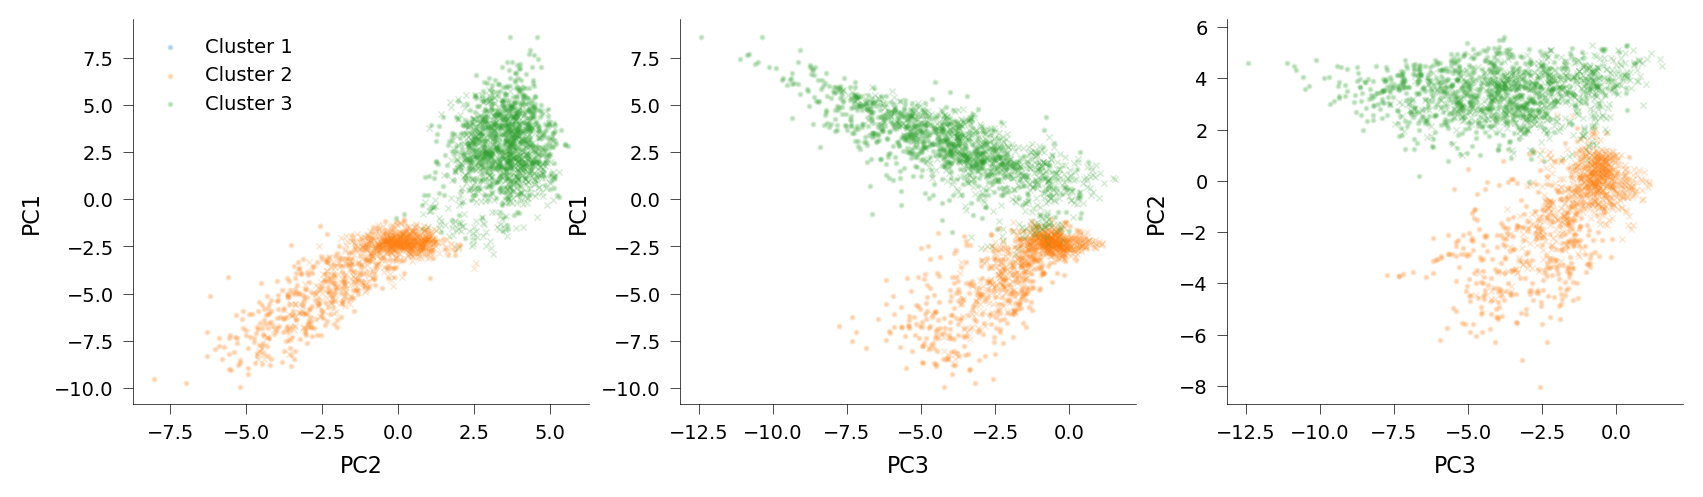

In [455]:
quant_use = slice(-100, 100)
quant_use = slice(0, 4)
# quant_use=slice(95, 100)
fig, ax = plt.subplots(1, 3)
fig_resize(fig, 10)
for i in range(ds_quant_sl.tau_lw.size):
    for j in range(n_clusters):
        mask_plot = ds_quant_sl['cluster_ind'] == j
        ax[0].scatter(ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=1, tau_lw=i).sel(quant=quant_use),
                      ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=0, tau_lw=i).sel(quant=quant_use),
                      marker=['.', 'x'][i], s=5, c=f'C{j}', alpha=0.2, label=f'Cluster {j + 1}' if i == 0 else None)
        ax[1].scatter(ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=2, tau_lw=i).sel(quant=quant_use),
                      ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=0, tau_lw=i).sel(quant=quant_use),
                      marker=['.', 'x'][i], s=5, c=f'C{j}', alpha=0.2)
        ax[2].scatter(ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=2, tau_lw=i).sel(quant=quant_use),
                      ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=1, tau_lw=i).sel(quant=quant_use),
                      marker=['.', 'x'][i], s=5, c=f'C{j}', alpha=0.2)

ax[0].set_ylabel('PC1')
ax[0].set_xlabel('PC2')
ax[1].set_xlabel('PC3')
ax[1].set_ylabel('PC1')
ax[2].set_xlabel('PC3')
ax[2].set_ylabel('PC2')
# ax[0].set_xlim(-10, 10)
# ax[0].set_ylim(-10, 5)
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax[0].legend()
plt.show()


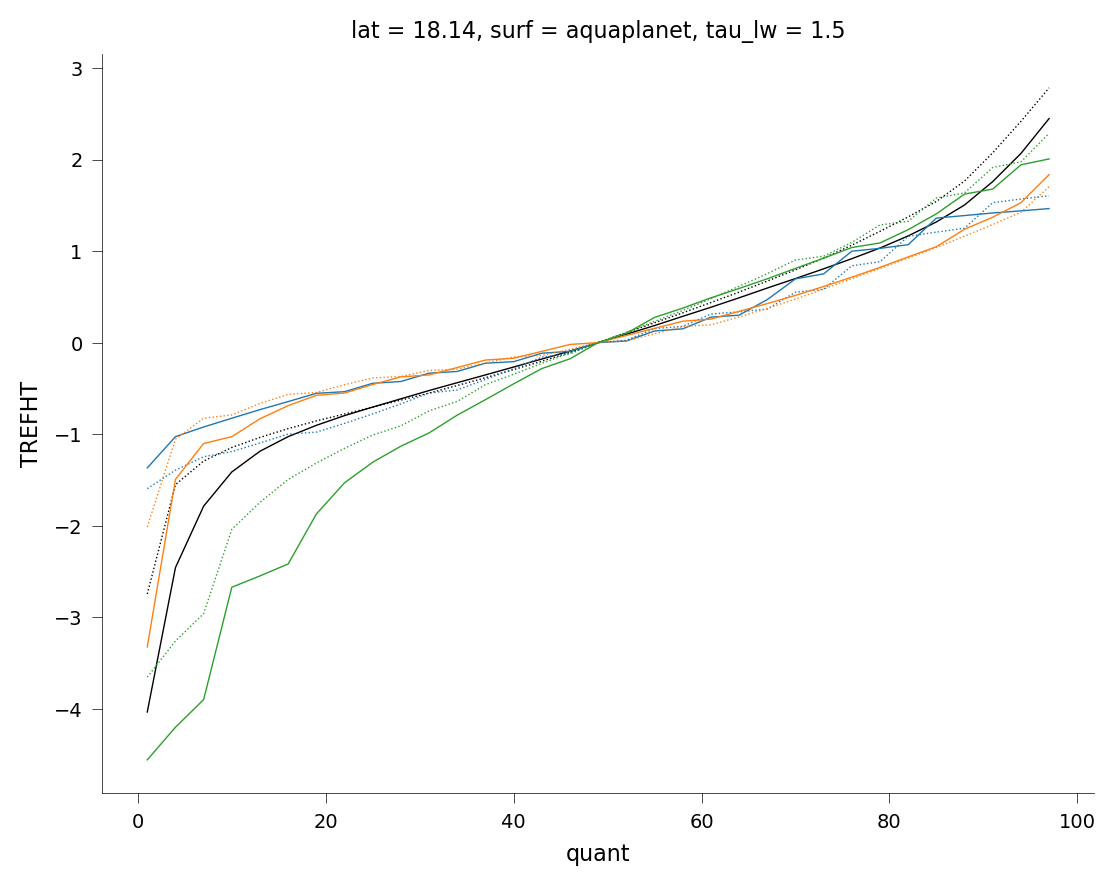

In [479]:
for i in range(2):
    (ds_quant_sl.TREFHT.isel(tau_lw=i).mean(dim='sample').squeeze() -
     ds_quant_sl.TREFHT.isel(tau_lw=i).mean(dim='sample').squeeze().sel(quant=49)).plot(color='k',
                                                                                        linestyle=[None, ':'][i])
for j in range(n_clusters):
    mask_plot = ds_quant_sl['cluster_ind'] == j
    for i in range(2):
        var = ds_quant_sl.TREFHT.where(mask_plot).isel(tau_lw=i).squeeze().quantile(ds_quant_sl.quant / 100,
                                                                                    dim=['quant', 'sample'])
        plt.plot(ds_quant_sl.quant, var - var.sel(quantile=0.49),
                 color=f'C{j}', linestyle=[None, ':'][i])

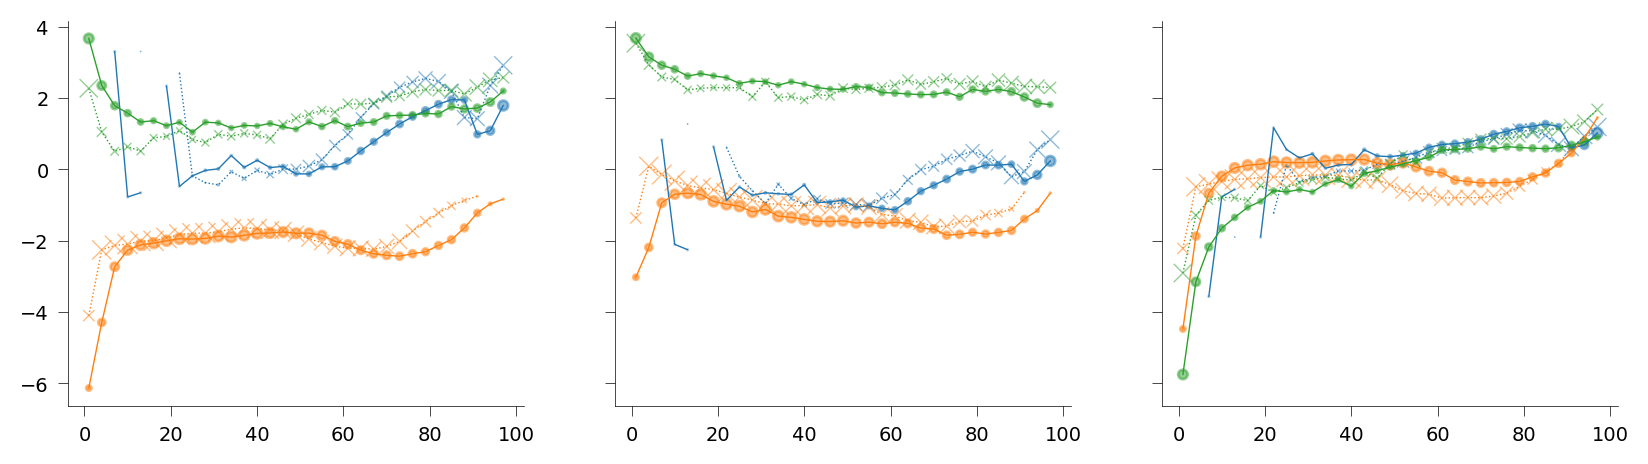

In [477]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)
for j in range(n_clusters):
    mask_plot = ds_quant_sl['cluster_ind'] == j
    n_sample_plot = mask_plot.sum(dim='sample')
    for k in range(ds_quant_sl.mode.size):
        var = ds_quant_sl['pc_coef'].where(mask_plot).isel(mode=k).mean(dim='sample')
        for i in range(ds_quant_sl.tau_lw.size - 0):
            ax[k].plot(ds_quant_sl.quant, var.isel(tau_lw=i), color=f"C{j}",
                       label=f'Cluster {j + 1}' if i == 0 else None,
                       linestyle=[None, ':'][i])
            ax[k].scatter(ds_quant_sl.quant, var.isel(tau_lw=i), s=n_sample_plot.isel(tau_lw=i) / 10, alpha=0.5,
                          color=f"C{j}",
                          marker=['.', 'x'][i])

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

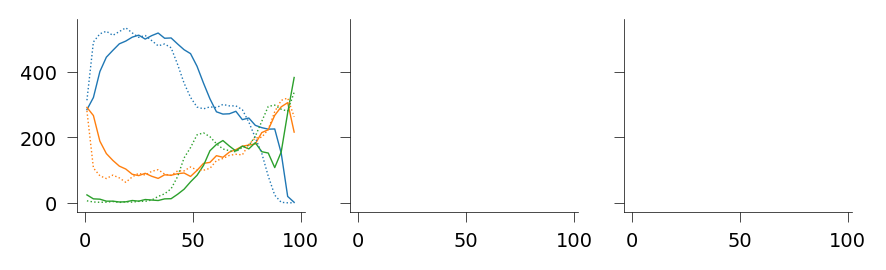

In [398]:
lat_ind_use = slice(0, 1)
lat_ind_use = slice(5, 8)
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    # ax.plot(ds_quant.quant, np.average((~mask_use).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use), axis=1,
    #                                    weights=lat_weights.isel(lat=lat_ind_use)) / ds_quant.sample.size,
    #         label="Non convective" if i == 0 else None, linestyle=[None, ':'][i], color='k')
    for j in range(n_clusters):
        n_day_cluster = ((cluster_ind == j)).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use)
        # n_day_total = ((~mask_use)).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use)
        # print(n_day_total)
        ax[0].plot(ds_quant.quant,
                   np.average(n_day_cluster, axis=1,
                              weights=lat_weights.isel(lat=lat_ind_use)),
                   linestyle=[None, ':'][i], color=f'C{j}', label=f'Cluster {j + 1}' if i == 0 else None)

ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
update_linewidth(fig)
ax.legend(title='$\kappa$')
plt.show()

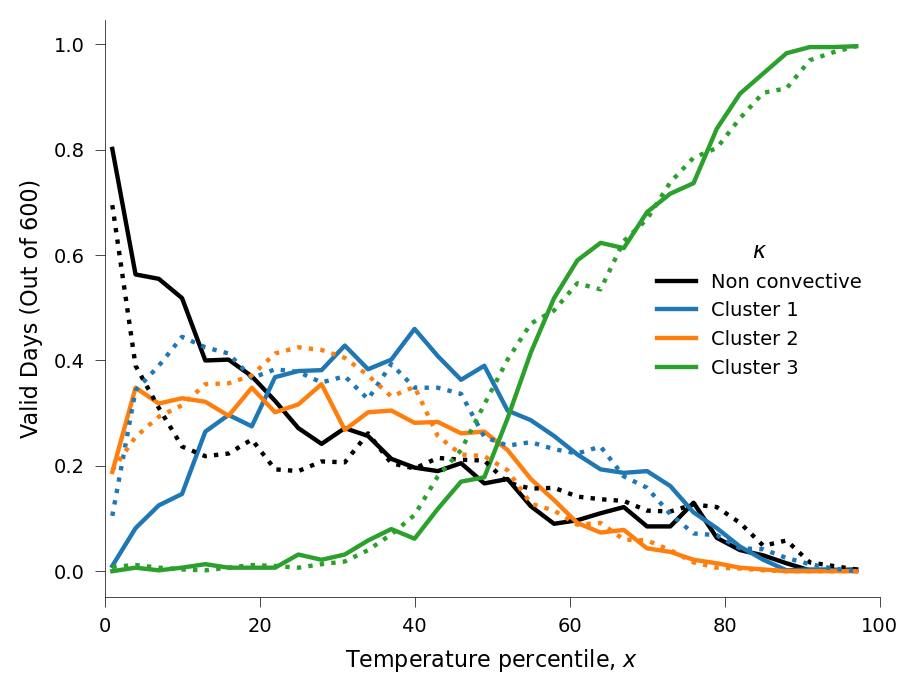

In [399]:
lat_ind_use = slice(0, 1)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    ax.plot(ds_quant.quant, np.average((~mask_use).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use), axis=1,
                                       weights=lat_weights.isel(lat=lat_ind_use)) / ds_quant.sample.size,
            label="Non convective" if i == 0 else None, linestyle=[None, ':'][i], color='k')
    for j in range(n_clusters):
        ax.plot(ds_quant.quant,
                np.average(((cluster_ind == j) & (mask_use)).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use), axis=1,
                           weights=lat_weights.isel(lat=lat_ind_use)) / ds_quant.sample.size,
                linestyle=[None, ':'][i], color=f'C{j}', label=f'Cluster {j + 1}' if i == 0 else None)

ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
update_linewidth(fig)
ax.legend(title='$\kappa$')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


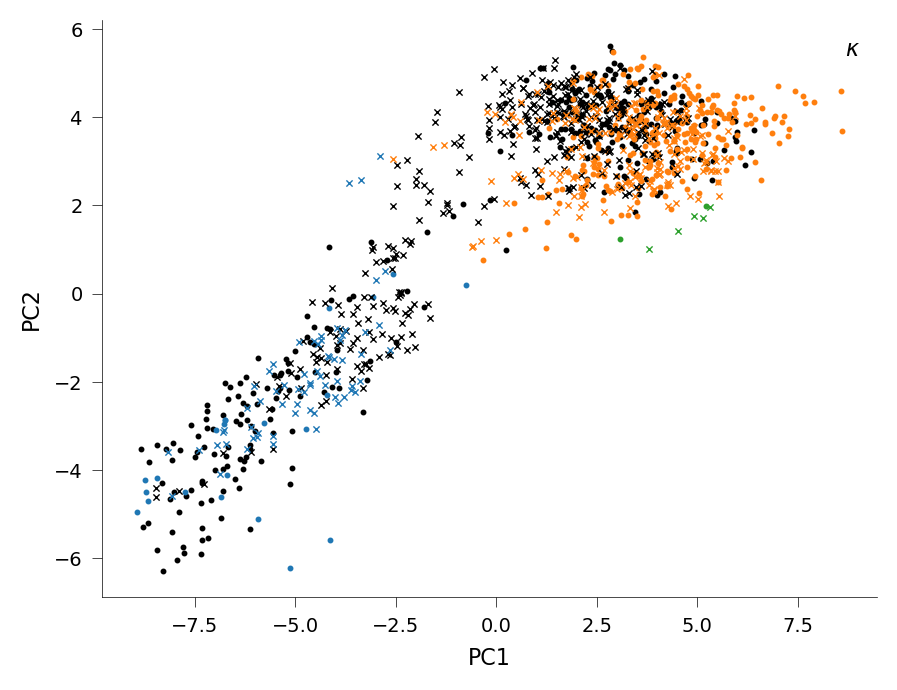

In [400]:
pc_output = pca_on_xarray(xr.concat(list(ds_pca.values()), dim="feature"), n_modes=3, feature_dim_name="feature",
                          valid=mask_use)
quant_use = slice(0, 200)
# lat_use = slice(0, 90)
quant_use = 0
lat_use = slice(5, 8)
lat_use = -1
var = pc_output[1].isel(quant=quant_use, lat=lat_use)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    mask_plot = ~mask_use.isel(quant=quant_use, lat=lat_use)
    ax.scatter(var.where(mask_plot).isel(mode=0, tau_lw=i),
               var.where(mask_plot).isel(mode=1, tau_lw=i), marker=['.', 'x'][i],
               s=5, c='k')
    for j in range(n_clusters):
        mask_plot = (mask_use.isel(quant=quant_use, lat=lat_use)) & (
                cluster_ind.isel(quant=quant_use, lat=lat_use) == j)
        ax.scatter(var.where(mask_plot).isel(mode=0, tau_lw=i),
                   var.where(mask_plot).isel(mode=1, tau_lw=i), marker=['.', 'x'][i], s=5, c=f'C{j}')
    # im = ax.scatter(var.isel(mode=0, tau_lw=0),
    #                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
    #                 c=ds_quant.TREFHT.where(mask_use * 0 + 1).isel(tau_lw=0, quant=quant_use, lat=lat_use),
    #                 alpha=0.3, label=var.tau_lw.values[0])
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=var.isel(mode=2, tau_lw=0),
#                 alpha=0.3, label=var.tau_lw.values[0])
# plt.colorbar(im, ax=ax)

# ax.scatter(var.isel(mode=0, tau_lw=0),
#            var.isel(mode=1, tau_lw=0), marker='.', s=1,
#            c='b', alpha=0.3, label=var.tau_lw.values[0])
# #
# ax.scatter(var.isel(mode=0, tau_lw=1),
#            var.isel(mode=1, tau_lw=1), marker='.', s=0.5,
#            c='y', alpha=0.3, label=var.tau_lw.values[1])


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax.legend(title='$\kappa$')
plt.show()


# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=-1), marker='.', s=1, color='C1')

# quant_use = -1
# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=1, lat=-1), marker='x', s=5, color='C0')
# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=-1), marker='x', s=5, color='C1')

# quant_use = -1
# plt.scatter(pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=0, mode=0),
#             pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=0, mode=1), marker='x', color='C0')
# plt.scatter(pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=1, mode=0),
#             pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=1, mode=1), marker='x', color='C1')
# plt.scatter(pc_output[1].isel(quant=0, tau_lw=1, mode=0), pc_output[1].isel(quant=0, tau_lw=1, mode=1))

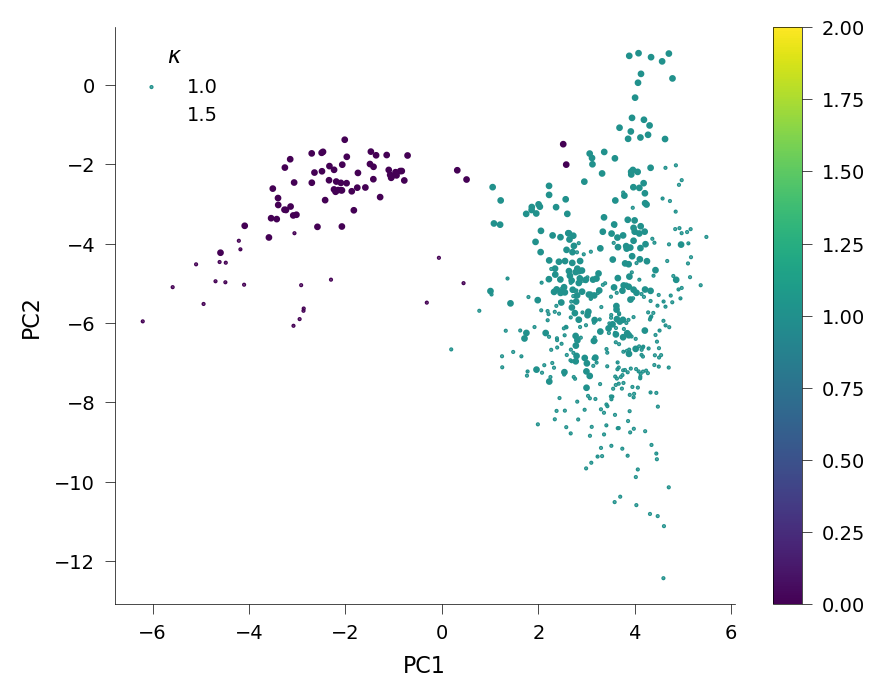

In [942]:
quant_use = slice(0, 200)
lat_use = slice(0, 90)
quant_use = 0
lat_use = -1
var = pc_output[1].where(mask_use).isel(quant=quant_use, lat=lat_use)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=ds_quant.TREFHT.where(mask_use * 0 + 1).isel(tau_lw=0, quant=quant_use, lat=lat_use),
#                 alpha=0.3, label=var.tau_lw.values[0])
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=var.isel(mode=2, tau_lw=0),
#                 alpha=0.3, label=var.tau_lw.values[0])
im = ax.scatter(var.isel(mode=1, tau_lw=0),
                var.isel(mode=2, tau_lw=0), marker='.', s=1,
                c=labels.where(mask_use).isel(quant=quant_use, lat=lat_use, tau_lw=0),
                alpha=1, label=var.tau_lw.values[0], vmin=0, vmax=2)

im = ax.scatter(var.isel(mode=1, tau_lw=1),
                var.isel(mode=2, tau_lw=1), marker='o', s=2,
                c=labels.where(mask_use).isel(quant=quant_use, lat=lat_use, tau_lw=1),
                alpha=1, label=var.tau_lw.values[1], vmin=0, vmax=2)

plt.colorbar(im, ax=ax)

# ax.scatter(var.isel(mode=0, tau_lw=0),
#            var.isel(mode=1, tau_lw=0), marker='.', s=1,
#            c='b', alpha=0.3, label=var.tau_lw.values[0])
# #
# ax.scatter(var.isel(mode=0, tau_lw=1),
#            var.isel(mode=1, tau_lw=1), marker='.', s=0.5,
#            c='y', alpha=0.3, label=var.tau_lw.values[1])


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax.legend(title='$\kappa$')
plt.show()

In [228]:
def value_counts_over_sample(da: xr.DataArray) -> xr.DataArray:
    """Count unique values along the sample dimension.

    Returns a DataArray with dims ('value', all other dims).
    """
    # identify all dims except sample
    other_dims = [d for d in da.dims if d != "sample"]

    # group along the sample dimension
    grouped = da.groupby(da).count("sample")

    # rename 'group' dim (the unique values)
    return grouped.rename({"group": "value"}).transpose("value", *other_dims)

In [941]:
np.unique(labels.where(mask_use).isel(quant=0, tau_lw=1, lat=-1).values, return_counts=True)

(array([ 0.,  1., nan]), array([ 65, 185, 350]))

(array([ 0.,  1., nan]), array([497,  91,  12]))
(array([ 0.,  1., nan]), array([506,  35,  59]))


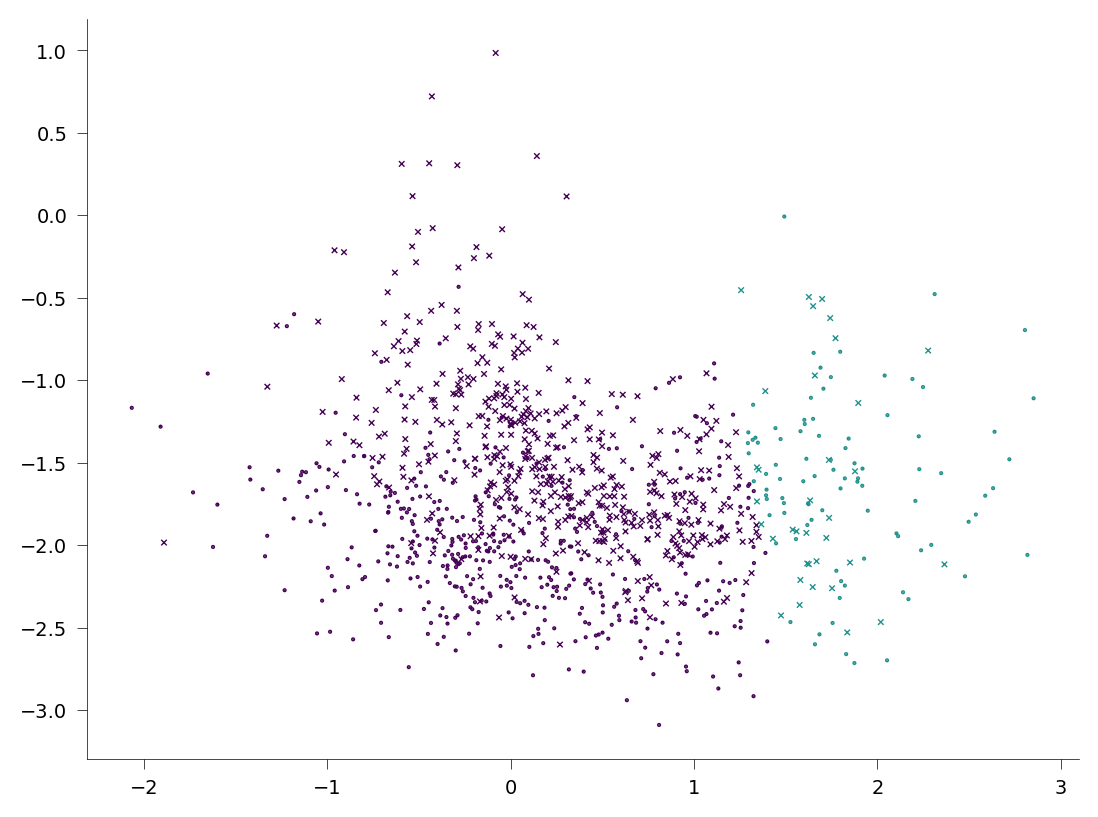

In [281]:
quant_use = slice(0, 90)
lat_use = slice(0, 90)
quant_use = -1
lat_use = -1

plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=0, lat=lat_use),
            pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=1, lat=lat_use), marker='.', s=1,
            c=labels.where(mask_use).isel(quant=quant_use, tau_lw=0, lat=lat_use), vmin=0, vmax=2)
print(np.unique(labels.where(mask_use).isel(quant=quant_use, tau_lw=0, lat=lat_use).values, return_counts=True))

plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=lat_use),
            pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=lat_use), marker='x', s=4,
            c=labels.where(mask_use).isel(quant=quant_use, tau_lw=1, lat=lat_use), vmin=0, vmax=2)
print(np.unique(labels.where(mask_use).isel(quant=quant_use, tau_lw=1, lat=lat_use).values, return_counts=True))

In [221]:
from sklearn.metrics import silhouette_score


def evaluate_k_range(
        pcs_A: xr.DataArray,
        mask_A: xr.DataArray,
        ks: list[int],
        pcs_B: xr.DataArray = None,
        mask_B: xr.DataArray = None,
) -> xr.Dataset:
    """Compute clustering diagnostics (elbow, silhouette, stability) for each K.

    If pcs_B and mask_B are given, computes the centroid stability measure:
        S(K) = mean_k ||μ_Ak - μ_ABk|| + ||μ_Bk - μ_ABk||

    Args:
        pcs_A: First dataset PCs (dims: quant, tau_lw, lat, sample, mode).
        mask_A: Boolean mask for dataset A.
        ks: List of cluster counts to evaluate.
        pcs_B: Optional second dataset PCs.
        mask_B: Corresponding mask.

    Returns:
        xr.Dataset containing diagnostics for each K:
            - inertia
            - silhouette
            - stability (if pcs_B provided)
    """
    results = {}

    # Stack once per dataset to avoid overhead
    def prepare(pcs, mask):
        pcs_st = pcs.stack(point=("quant", "lat", "sample"))
        mask_st = mask.stack(point=("quant", "lat", "sample"))
        X = pcs_st.transpose("point", "mode").values
        X_mask = pcs_st.sel(point=mask_st).transpose("point", "mode").values
        return pcs_st, mask_st, X, X_mask

    pcsA_st, maskA_st, XA_full, XA_mask = prepare(pcs_A, mask_A)
    if pcs_B is not None:
        pcsB_st, maskB_st, XB_full, XB_mask = prepare(pcs_B, mask_B)
        # Combined dataset for AB fit
        XAB_mask = np.vstack([XA_mask, XB_mask])
    else:
        XAB_mask = None

    for K in ks:
        kmA = KMeans(n_clusters=K, n_init="auto").fit(XA_mask)
        inertia = kmA.inertia_
        sil = silhouette_score(XA_mask, kmA.labels_) if len(set(kmA.labels_)) > 1 else np.nan

        # Default output for a single dataset
        entry = dict(inertia=inertia, silhouette=sil)

        # If two datasets supplied, compute stability
        if pcs_B is not None:
            kmB = KMeans(n_clusters=K, n_init="auto").fit(XB_mask)
            kmAB = KMeans(n_clusters=K, n_init="auto").fit(XAB_mask)

            muA = kmA.cluster_centers_
            muB = kmB.cluster_centers_
            muAB = kmAB.cluster_centers_

            # Compute ∥μA−μAB∥ + ∥μB−μAB∥ per k, then average
            stab = np.mean(
                np.linalg.norm(muA - muAB, axis=1) +
                np.linalg.norm(muB - muAB, axis=1)
            )
            entry["stability"] = stab

        results[K] = entry

    # Convert to xarray
    ds = xr.Dataset(
        {
            k: xr.DataArray(
                [results[k]["inertia"],
                 results[k]["silhouette"]] +
                ([results[k]["stability"]] if pcs_B is not None else []),
                dims=["metric"],
                coords=dict(metric=(["metric"],
                                    ["inertia", "silhouette"] +
                                    (["stability"] if pcs_B is not None else [])
                                    ))
            )
            for k in ks
        }
    )

    return ds

In [225]:
kmeans_diagnostics = evaluate_k_range(pc_output[1].isel(tau_lw=0), mask_use.isel(tau_lw=0), [2, 3, 4, 5],
                                      pc_output[1].isel(tau_lw=1), mask_use.isel(tau_lw=1))

In [226]:
kmeans_diagnostics

<xarray.Dataset> Size: 216B
Dimensions:  (metric: 3)
Coordinates:
  * metric   (metric) <U10 120B 'inertia' 'silhouette' 'stability'
Data variables:
    2        (metric) float64 24B 2.02e+05 0.4967 4.695
    3        (metric) float64 24B 1.173e+05 0.4346 3.634
    4        (metric) float64 24B 9.768e+04 0.3795 2.485
    5        (metric) float64 24B 7.905e+04 0.3642 4.477